In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

In [51]:
# --- PASSO 1: Definir a Camada Personalizada ---
# Colocamos a definição exata aqui para garantir a compatibilidade.
class ResizingLayer(layers.Layer):
    def __init__(self, target_length, **kwargs):
        super(ResizingLayer, self).__init__(**kwargs)
        self.target_length = target_length

    def call(self, inputs):
        reshaped_tensor = tf.expand_dims(inputs, axis=1)
        resized = tf.image.resize(reshaped_tensor, [1, self.target_length], method='bilinear')
        return tf.squeeze(resized, axis=1)

    def get_config(self):
        config = super(ResizingLayer, self).get_config()
        config.update({"target_length": self.target_length})
        return config

# --- PASSO 2: Definir a Classe do Modelo ---
# Esta é a arquitetura exata para a qual os pesos foram treinados.
class KB2SPlusModel(keras.Model):
    def __init__(self, input_shape, num_classes, **kwargs):
        super(KB2SPlusModel, self).__init__(**kwargs)
        self.input_shape_param = input_shape
        self.num_classes = num_classes
        self._build_model()

    def _build_model(self):
        inputs = keras.Input(shape=self.input_shape_param) 
        x = layers.Masking(mask_value=0.0)(inputs)
        
        filters = [128]*5; kernel_sizes = [75, 35, 15, 5, 3]; pool_sizes = [10, 10, 5, 5, 2]
        module_outputs = []
        
        for i in range(5):
            module_input = x
            conv1 = layers.Conv1D(filters=filters[i], kernel_size=kernel_sizes[i], padding='same', activation='relu', name=f'conv1_module_{i+1}')(module_input)
            conv2 = layers.Conv1D(filters=filters[i], kernel_size=kernel_sizes[i], padding='same', activation='relu', name=f'conv2_module_{i+1}')(conv1)
            pool = layers.MaxPooling1D(pool_size=pool_sizes[i], padding='same', name=f'pool_module_{i+1}')(conv2)
            module_outputs.append(pool)
            
            if i > 0:
                concatenated_features = []
                current_shape_len = tf.keras.backend.int_shape(pool)[1]
                for j, prev_output in enumerate(module_outputs[:-1]):
                    adapted = ResizingLayer(target_length=current_shape_len, name=f'resize_layer_{i}_{j}')(prev_output)
                    concatenated_features.append(adapted)
                concatenated_features.append(pool)
                x = layers.Concatenate(axis=-1, name=f'concat_module_{i+1}')(concatenated_features)
            else: x = pool
                
        x = layers.GlobalAveragePooling1D(name='global_avg_pool')(x)
        x = layers.Dense(256, activation='relu', name='fc1')(x); x = layers.Dropout(0.5, name='dropout1')(x)
        x = layers.Dense(128, activation='relu', name='fc2')(x); x = layers.Dropout(0.3, name='dropout2')(x)
        x = layers.Dense(64, activation='relu', name='fc3')(x); x = layers.Dropout(0.2, name='dropout3')(x)
        outputs = layers.Dense(self.num_classes, activation='softmax', name='softmax_output')(x)
        
        self.model = keras.Model(inputs=inputs, outputs=outputs, name='KB2S_Plus_Restored')

    def call(self, inputs):
        return self.model(inputs)
    
    def summary(self):
        self.model.summary()

print("Definições do modelo e da camada personalizada prontas.")

Definições do modelo e da camada personalizada prontas.


In [53]:
# --- PASSO 3: Construir a Estrutura do Modelo Vazio ---
INPUT_SHAPE = (8000, 1)
NUM_CLASSES = 4

print("1. Construindo a arquitetura do modelo...")
model = KB2SPlusModel(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES)

# --- PASSO 4: Forçar a Construção das Camadas ---
print("2. Forçando a criação das variáveis internas do modelo...")
dummy_input = tf.zeros((1, INPUT_SHAPE[0], INPUT_SHAPE[1]))
model(dummy_input)

# --- PASSO 5: Carregar os Pesos Salvos ---
print("3. Carregando os pesos treinados no modelo...")
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
pesos_path = os.path.join(base_dir, 'models', 'modelo13_10_25', 'kb2s_plus_trained_weights.weights.h5')

try:
    # CORREÇÃO 1: Carregamos os pesos no modelo INTERNO (model.model)
    model.model.load_weights(pesos_path)
    
    print("\n✅ Sucesso! Os pesos treinados foram carregados no modelo.")
    
    # CORREÇÃO 2: Compilamos o modelo INTERNO (model.model)
    model.model.compile(
        optimizer='adam', 
        loss='sparse_categorical_crossentropy', 
        metrics=['accuracy']
    )
    print("Modelo compilado e pronto para a inferência.")
    
except Exception as e:
    print(f"\n❌ ERRO ao carregar os pesos: {e}")

# Finalmente, exibimos o summary do modelo INTERNO para confirmar
model.model.summary()

1. Construindo a arquitetura do modelo...
2. Forçando a criação das variáveis internas do modelo...
3. Carregando os pesos treinados no modelo...

✅ Sucesso! Os pesos treinados foram carregados no modelo.
Modelo compilado e pronto para a inferência.
Model: "KB2S_Plus_Restored"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 8000, 1)]    0           []                               
                                                                                                  
 masking_6 (Masking)            (None, 8000, 1)      0           ['input_7[0][0]']                
                                                                                                  
 conv1_module_1 (Conv1D)        (None, 8000, 128)    9728        ['masking_6[0][0]']              
                             

--- Teste de Sanidade: Usando um arquivo do dataset final ---
1/1 [==============================] - 0s 18ms/step

--- Resultado da Predição ---
Arquivo Testado: 1077181.npy
Classe Original (pela pasta): AF
Classe Prevista pelo Modelo: AF
Confiança da Predição: 99.93%

Probabilidades para cada classe:
  - AF: 99.93%
  - N: 0.01%
  - O: 0.06%
  - RUIDO: 0.00%


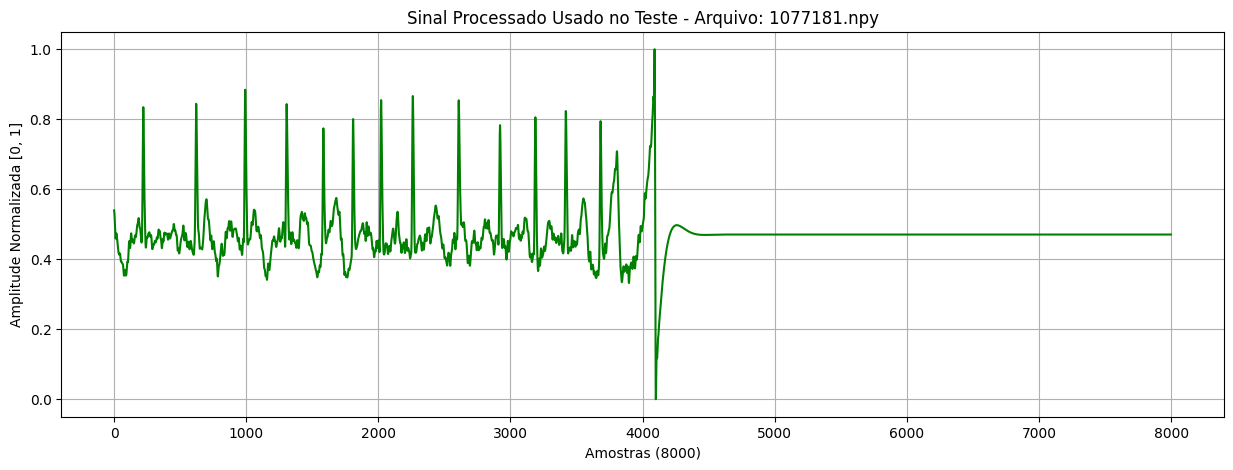

In [86]:
import random
import numpy as np
import matplotlib.pyplot as plt
import os

# --- 1. Verificar se o modelo está carregado ---
if 'model' not in locals() or model.model is None:
    print("❌ ERRO: A variável 'model' não foi encontrada ou o modelo interno não está pronto.")
    print("Por favor, execute a célula de carregamento do modelo primeiro.")
else:
    # --- 2. Definir os caminhos e escolher um arquivo aleatório ---
    final_processed_dir = os.path.join(base_dir, 'data', 'processed', 'filtrados_e_processado')
    
    # Lista de todas as pastas com dados processados
    class_folders = ['AF', 'N', 'O', 'RUIDO', 'RUIDO_GERADOS']
    
    # Escolhe uma pasta de classe aleatoriamente
    random_class_folder = random.choice(class_folders)
    class_path = os.path.join(final_processed_dir, random_class_folder)
    
    # Escolhe um arquivo .npy aleatório dentro da pasta
    random_file = random.choice(os.listdir(class_path))
    file_path = os.path.join(class_path, random_file)

    print("--- Teste de Sanidade: Usando um arquivo do dataset final ---")

    # --- 3. Carregar o sinal (ele JÁ ESTÁ processado) ---
    signal_to_predict = np.load(file_path)

    # --- 4. Preparar o tensor para o modelo ---
    # Adiciona a dimensão do lote (batch) e a dimensão do canal (channel)
    input_tensor = np.expand_dims(signal_to_predict, axis=0) # Shape -> (1, 8000)
    input_tensor = np.expand_dims(input_tensor, axis=-1)   # Shape -> (1, 8000, 1)

    # --- 5. Fazer a predição usando o modelo interno ---
    prediction_probabilities = model.model.predict(input_tensor)[0]

    # --- 6. Interpretar o resultado ---
    class_names = ['AF', 'N', 'O', 'RUIDO'] # Ordem do LabelEncoder do treinamento
    predicted_class_index = np.argmax(prediction_probabilities)
    predicted_class_name = class_names[predicted_class_index]
    prediction_confidence = prediction_probabilities[predicted_class_index]

    print("\n--- Resultado da Predição ---")
    print(f"Arquivo Testado: {random_file}")
    # Para o rótulo verdadeiro, consideramos RUIDO e RUIDO_GERADOS como a mesma classe
    true_label = 'RUIDO' if 'RUIDO' in random_class_folder else random_class_folder
    print(f"Classe Original (pela pasta): {true_label}")
    print(f"Classe Prevista pelo Modelo: {predicted_class_name}")
    print(f"Confiança da Predição: {prediction_confidence:.2%}")
    print("\nProbabilidades para cada classe:")
    for i, name in enumerate(class_names):
        print(f"  - {name}: {prediction_probabilities[i]:.2%}")
        
    # --- 7. Plotar o sinal que o modelo viu ---
    plt.figure(figsize=(15, 5))
    plt.plot(signal_to_predict, color='green')
    plt.title(f'Sinal Processado Usado no Teste - Arquivo: {random_file}')
    plt.xlabel('Amostras (8000)')
    plt.ylabel('Amplitude Normalizada [0, 1]')
    plt.grid(True)
    plt.show()